In [1]:
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import classification_report

In [5]:
path_to_train='Train/'
path_to_valid = 'Valid/'
path_to_test='Test/'

In [6]:
X_train=np.load(path_to_train+"X_train.npy")
X_valid=np.load(path_to_valid+"X_valid.npy")

In [7]:
y_train_superclass=np.load(path_to_train+"y_train_superclass.npy")
y_valid_superclass=np.load(path_to_valid+"y_valid_superclass.npy")

In [8]:
batch_size = 128

In [9]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train_superclass)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

X_valid_tensor = torch.Tensor(X_valid)
y_valid_tensor = torch.LongTensor(y_valid_superclass)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

In [10]:
X_test=np.load(path_to_test+"X_test.npy")
y_test=np.load(path_to_test+"y_test_superclass.npy")

In [11]:
def train(epoch,my_model, data_loader, optimizer, loss_function):
    losses=[]
    my_model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        output = my_model(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X_batch), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
        losses.append(loss.data.numpy())
    return np.mean(losses)

In [12]:
def test(my_model, data_loader, loss_function):
    accuracy_arr = []
    my_model.eval()
    test_loss = 0
    correct = 0
    for X_batch, y_batch in data_loader:
        output = my_model(X_batch)
        test_loss += loss_function(output, y_batch).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_batch.data.view_as(pred)).cpu().sum()

    test_loss /= len(data_loader)
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return acc,test_loss

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [14]:
def training(number_of_epoches, model, optimizer, loss_function, learning_rate, train_loader, valid_loader):
    loss_train=[]
    loss_valid=[]
    acc=[]
    best_accuracy, last_accuracy = 0, 0
    patience = 3
    trigger_times = 0 
    
    for epoch in range(number_of_epoches):
        loss_train.append(train(epoch + 1,model, train_loader, optimizer, loss_function))
        accuracy, current_loss = test(model, valid_loader, loss_function)
        acc.append(accuracy)
        loss_valid.append(current_loss)
        if accuracy < last_accuracy:
            trigger_times += 1
            if trigger_times > patience:
                break
        else:
            trigger_times = 0  
        if epoch ==int(number_of_epoches * 0.3):
            optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)    
        print("Trigger times", trigger_times) 
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        last_accuracy = accuracy
        
    return loss_train, loss_valid, acc

In [15]:
del X_train
del X_valid

del y_train_superclass
del y_valid_superclass

del X_train_tensor
del y_train_tensor

del X_valid_tensor
del y_valid_tensor

In [16]:
PI = torch.from_numpy(np.array(np.pi))
from torch.nn import functional as F

In [17]:
input_shape = 1000

In [18]:
class SincNet(nn.Module):
    
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)
    
    def __init__(self, input_shape, number_of_filters, filter_length, min_low_hz=80, min_band_hz=80):
        super().__init__()
        self.number_of_filters = number_of_filters
        self.filter_length = filter_length
        self.sample_rate = 100        
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz
        
        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.number_of_filters + 1)
        hz = self.to_hz(mel)
        
        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))
           
        
        self.LeakyReLU = nn.LeakyReLU(0.01)
         
        
       
    def forward(self, x):
                        
        n = torch.arange(0, self.filter_length // 2.0).view(1, -1)     
        f_1 = self.min_low_hz  + torch.abs(self.low_hz_)       
        f_2 = torch.clamp(f_1 + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(f_2-f_1)[:,0]        
        
        g_filter = 2 * f_2 * torch.sinc(2 * PI * f_2 * n) - 2 * f_1 *torch.sinc(2 * PI * f_1 * n)
        
        window = 0.54 - 0.46 * torch.cos(2* PI * n)/ self.filter_length  
        g_filter_w = g_filter * window 
        g_filter_center = 2*band.view(-1,1)
        g_filter_right= torch.flip(g_filter_w,dims=[1])        
        g_filter_w =torch.cat([g_filter_w,g_filter_center,g_filter_right],dim=1)        
        g_filter_w = g_filter_w / (2*band[:,None])        
        filters = (g_filter_w).view(self.number_of_filters, 1, self.filter_length)  
        
        results = F.conv1d(x, filters)
        results = self.LeakyReLU(results)    

                
        return results

In [34]:
class CNN_with_SincNet(nn.Module):
    def __init__(self, input_shape,n_outputs, number_of_filters, filter_length, kernel_size):
        super().__init__()
        self.models_list = []
        self.models_ = []
        
        for i in range(12):
            self.models_list.append(self.SincNet_layer(input_shape, NUMBER_OF_FILTERS, L))
            
            
        self.conv1D_1 = nn.Conv1d(in_channels = 12 * number_of_filters, out_channels = 64, kernel_size = kernel_size[0], padding = 2)
        self.bn_1 = nn.BatchNorm1d(64)
        self.leakyReLU_1 = nn.LeakyReLU(0.01)
        self.maxpool = nn.MaxPool1d(2)
        self.conv1D_2 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[1], padding = 2)
        self.bn_2 = nn.BatchNorm1d(64)        
        self.leakyReLU_2 = nn.LeakyReLU(0.01)
        self.maxpool2 = nn.MaxPool1d(2)
        self.conv1D_3 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[2], padding = 2)
        self.bn_3 = nn.BatchNorm1d(64)
        self.leakyReLU_3 = nn.LeakyReLU(0.01)
        self.maxpool3 = nn.MaxPool1d(2)        
        self.conv1D_4 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[3], padding = 2)
        self.bn_4 = nn.BatchNorm1d(64)
        self.leakyReLU_4 = nn.LeakyReLU(0.01)    
        self.maxpool4 = nn.MaxPool1d(2)
        self.conv1D_5 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[4], padding = 2)
        self.bn_5 = nn.BatchNorm1d(64)
        self.leakyReLU_5 = nn.LeakyReLU(0.01)
        self.maxpool5 = nn.MaxPool1d(2)
        self.adAvgPooling = nn.AdaptiveAvgPool1d(2)        
        self.fl = nn.Flatten()
        
        self.lin1 = nn.Linear(2 * 64, 128)
        self.bn_6 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.6)
        self.leakyReLU_6 = nn.LeakyReLU(0.01)        

        self.lin2 = nn.Linear(128, n_outputs)
        self.softmax = nn.Softmax(dim=1)

        
    def SincNet_layer(self, input_shape, number_of_filters,length):    
        return nn.Sequential(SincNet(input_shape, number_of_filters, length))

    def forward(self, x):
        outputs = []
        
        data = np.array(x)
        data = np.array(np.split(data,12,axis = 1))
        data = torch.tensor(data)
        
        
        for i in range(12):
            outputs.append(self.models_list[i](data[i]))
        
        output = outputs[0]
        for i in range(1,12):
            output = torch.cat((output,outputs[i]), axis = 1)
         
        output = self.conv1D_1(output)
        output = self.bn_1(output)
        output = self.leakyReLU_1(output)
        output = self.maxpool(output)
        output = self.conv1D_2(output)
        output = self.bn_2(output)
        output = self.leakyReLU_2(output)
        output = self.maxpool2(output)
        output = self.conv1D_3(output)
        output = self.bn_3(output)
        output = self.leakyReLU_3(output)
        output = self.maxpool3(output)
        output = self.conv1D_4(output)
        output = self.bn_4(output)
        output = self.leakyReLU_4(output)
        output = self.maxpool4(output)
        output = self.conv1D_5(output)
        output = self.bn_5(output)
        output = self.leakyReLU_5(output)
        output = self.maxpool5(output)
        output = self.adAvgPooling(output)
        output = self.fl(output)
        

        output = self.lin1(output)
        output = self.bn_6(output)
        output = self.drop1(output)
        output = self.leakyReLU_6(output)
        output = self.lin2(output)
        output = self.softmax(output)        
        
        
        return output        
    
    
    

In [35]:
loss_function=nn.CrossEntropyLoss()

In [36]:
learning_rate = 0.001
learning_rate_2 = 0.0001

In [37]:
input_shape=1000

In [38]:
NUMBER_OF_FILTERS = 5
L = 23

In [39]:
model = CNN_with_SincNet(input_shape, 5, NUMBER_OF_FILTERS, L, [5,5,5,5,5])

In [40]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [41]:
loss_train, loss_valid, accuracy = training(30, model, optimizer, loss_function, learning_rate_2, train_loader, valid_loader)

Train Epoch: 1 [0/12069 (0%)]	Loss: 1.610997
Train Epoch: 1 [1280/12069 (11%)]	Loss: 1.435321
Train Epoch: 1 [2560/12069 (21%)]	Loss: 1.365836
Train Epoch: 1 [3840/12069 (32%)]	Loss: 1.266364
Train Epoch: 1 [5120/12069 (42%)]	Loss: 1.284053
Train Epoch: 1 [6400/12069 (53%)]	Loss: 1.312670
Train Epoch: 1 [7680/12069 (63%)]	Loss: 1.261853
Train Epoch: 1 [8960/12069 (74%)]	Loss: 1.213193
Train Epoch: 1 [10240/12069 (84%)]	Loss: 1.262248
Train Epoch: 1 [11520/12069 (95%)]	Loss: 1.214138

Test set: Average loss: 1.2279, Accuracy: 1764/2587 (68.19%)

Trigger times 0
Train Epoch: 2 [0/12069 (0%)]	Loss: 1.217867
Train Epoch: 2 [1280/12069 (11%)]	Loss: 1.227623
Train Epoch: 2 [2560/12069 (21%)]	Loss: 1.226743
Train Epoch: 2 [3840/12069 (32%)]	Loss: 1.245870
Train Epoch: 2 [5120/12069 (42%)]	Loss: 1.144640
Train Epoch: 2 [6400/12069 (53%)]	Loss: 1.184842
Train Epoch: 2 [7680/12069 (63%)]	Loss: 1.174711
Train Epoch: 2 [8960/12069 (74%)]	Loss: 1.227083
Train Epoch: 2 [10240/12069 (84%)]	Loss: 1.19

Train Epoch: 15 [6400/12069 (53%)]	Loss: 1.086297
Train Epoch: 15 [7680/12069 (63%)]	Loss: 1.106884
Train Epoch: 15 [8960/12069 (74%)]	Loss: 1.093299
Train Epoch: 15 [10240/12069 (84%)]	Loss: 1.064053
Train Epoch: 15 [11520/12069 (95%)]	Loss: 1.106951

Test set: Average loss: 1.1512, Accuracy: 1945/2587 (75.18%)

Trigger times 1
Train Epoch: 16 [0/12069 (0%)]	Loss: 1.058732
Train Epoch: 16 [1280/12069 (11%)]	Loss: 1.110057
Train Epoch: 16 [2560/12069 (21%)]	Loss: 1.084499
Train Epoch: 16 [3840/12069 (32%)]	Loss: 1.119214
Train Epoch: 16 [5120/12069 (42%)]	Loss: 1.044380
Train Epoch: 16 [6400/12069 (53%)]	Loss: 1.077491
Train Epoch: 16 [7680/12069 (63%)]	Loss: 1.072300
Train Epoch: 16 [8960/12069 (74%)]	Loss: 1.067887
Train Epoch: 16 [10240/12069 (84%)]	Loss: 1.117410
Train Epoch: 16 [11520/12069 (95%)]	Loss: 1.109266

Test set: Average loss: 1.1490, Accuracy: 1943/2587 (75.11%)

Trigger times 2
Train Epoch: 17 [0/12069 (0%)]	Loss: 1.078591
Train Epoch: 17 [1280/12069 (11%)]	Loss: 1.145

Train Epoch: 29 [10240/12069 (84%)]	Loss: 1.031439
Train Epoch: 29 [11520/12069 (95%)]	Loss: 1.082425

Test set: Average loss: 1.1441, Accuracy: 1965/2587 (75.96%)

Trigger times 1
Train Epoch: 30 [0/12069 (0%)]	Loss: 1.062541
Train Epoch: 30 [1280/12069 (11%)]	Loss: 1.088919
Train Epoch: 30 [2560/12069 (21%)]	Loss: 1.092216
Train Epoch: 30 [3840/12069 (32%)]	Loss: 1.060038
Train Epoch: 30 [5120/12069 (42%)]	Loss: 1.105212
Train Epoch: 30 [6400/12069 (53%)]	Loss: 1.041983
Train Epoch: 30 [7680/12069 (63%)]	Loss: 1.083822
Train Epoch: 30 [8960/12069 (74%)]	Loss: 1.114400
Train Epoch: 30 [10240/12069 (84%)]	Loss: 1.054096
Train Epoch: 30 [11520/12069 (95%)]	Loss: 1.039610

Test set: Average loss: 1.1413, Accuracy: 1957/2587 (75.65%)

Trigger times 2


In [42]:
print_confusion_matrix(model, X_test, y_test)

[[300  74   7  43  28]
 [ 41 352   1  45  55]
 [ 10  10  48  34  12]
 [ 45  27   9 335  62]
 [ 12  38   6  63 929]]
Accuracy = 0.7594740912606341


0.7594740912606341

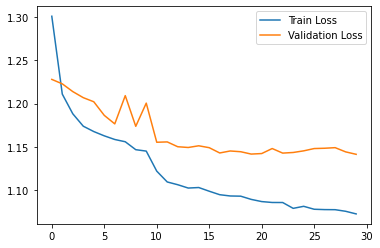

In [43]:
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_valid, label = 'Validation Loss')
plt.legend()
plt.show()

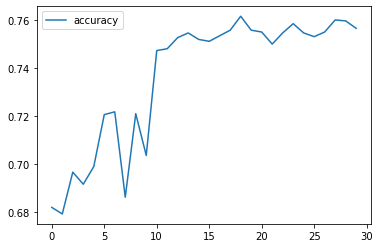

In [44]:
plt.plot(accuracy, label = 'accuracy')
plt.legend()
plt.show()

In [45]:
print("Best accuracy: ",np.max(accuracy)," Epoch: ", np.argmax(accuracy)+1)

Best accuracy:  0.7614998  Epoch:  19


In [46]:
model.eval()
y_pred = model(torch.Tensor(X_test)).data.numpy().argmax(axis = 1)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       452
           1       0.70      0.71      0.71       494
           2       0.68      0.42      0.52       114
           3       0.64      0.70      0.67       478
           4       0.86      0.89      0.87      1048

    accuracy                           0.76      2586
   macro avg       0.72      0.68      0.69      2586
weighted avg       0.76      0.76      0.76      2586



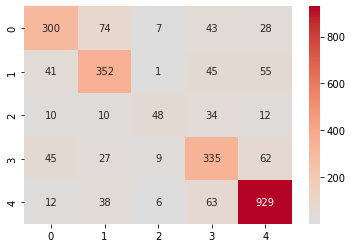

In [48]:
cm = confusion_matrix(y_test,y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', center = 0)